In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [2]:
# Cell 1
import os, sys, math, glob, random, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models, utils as tvutils
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
set_seed(42)

Device: cuda


In [3]:
# Cell 2
from pathlib import Path
import os

def find_archive_root(hint="archive"):
    """
    Try to locate the 'archive' directory starting from CWD.
    If CWD already *is* archive, return it. Otherwise look for a child named 'archive'.
    Finally, scan a few guess paths (Desktop/AS10/archive).
    """
    cwd = Path.cwd()
    # Case 1: we're already inside 'archive'
    if cwd.name == hint and cwd.is_dir():
        return cwd

    # Case 2: ./archive relative to current folder
    here = cwd / hint
    if here.is_dir():
        return here

    # Case 3: look one level up
    up = cwd.parent / hint
    if up.is_dir():
        return up

    # Case 4: try a common absolute the user mentioned
    guesses = [
        Path.home() / "Desktop" / "AS10" / "archive",
        Path("/home/akif/Desktop/AS10/archive"),
    ]
    for g in guesses:
        if g.is_dir():
            return g

    # Last resort: walk up a few levels and look for a folder literally named 'archive'
    cur = cwd
    for _ in range(4):
        cand = cur / hint
        if cand.is_dir():
            return cand
        cur = cur.parent

    raise FileNotFoundError("Could not locate the 'archive' directory. "
                            "Set ARCHIVE_ROOT manually to the absolute path.")

# --- detect root and actual left/right dirs ---
ARCHIVE_ROOT = find_archive_root("archive")

# Support both flat and nested patterns
flat_left  = ARCHIVE_ROOT / "left"
flat_right = ARCHIVE_ROOT / "right"
nest_left  = ARCHIVE_ROOT / "left" / "left"
nest_right = ARCHIVE_ROOT / "right" / "right"

LEFT_DIRS_ACTUAL  = []
RIGHT_DIRS_ACTUAL = []

if nest_left.is_dir():
    LEFT_DIRS_ACTUAL.append(nest_left)
if flat_left.is_dir():
    LEFT_DIRS_ACTUAL.append(flat_left)

if nest_right.is_dir():
    RIGHT_DIRS_ACTUAL.append(nest_right)
if flat_right.is_dir():
    RIGHT_DIRS_ACTUAL.append(flat_right)

if not LEFT_DIRS_ACTUAL or not RIGHT_DIRS_ACTUAL:
    raise RuntimeError(
        f"Found archive at: {ARCHIVE_ROOT}\n"
        f"But couldn't find left/right under either pattern:\n"
        f" - {nest_left}\n - {flat_left}\n - {nest_right}\n - {flat_right}"
    )

OUT_DIR = Path("outputs/contrastive")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Archive root:", ARCHIVE_ROOT.resolve())
print("Left dirs found:", [str(p) for p in LEFT_DIRS_ACTUAL])
print("Right dirs found:", [str(p) for p in RIGHT_DIRS_ACTUAL])

Archive root: /home/akif/Desktop/archive
Left dirs found: ['/home/akif/Desktop/archive/left/left', '/home/akif/Desktop/archive/left']
Right dirs found: ['/home/akif/Desktop/archive/right/right', '/home/akif/Desktop/archive/right']


In [4]:
# Cell 2.1
from itertools import islice

def list_some(p, n=3):
    files = [q for q in p.rglob("*") if q.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
    print(f"{p} -> {len(files)} images")
    for q in islice(files, 5):
        print("  -", q.name)
    return files

left_counts = sum(len([q for q in d.rglob('*') if q.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.webp'}]) 
                  for d in LEFT_DIRS_ACTUAL)
right_counts = sum(len([q for q in d.rglob('*') if q.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.webp'}]) 
                   for d in RIGHT_DIRS_ACTUAL)

print(f"Total LEFT images:  {left_counts}")
print(f"Total RIGHT images: {right_counts}")

# Print samples from the first detected left/right directory
if LEFT_DIRS_ACTUAL:  list_some(LEFT_DIRS_ACTUAL[0])
if RIGHT_DIRS_ACTUAL: list_some(RIGHT_DIRS_ACTUAL[0])

Total LEFT images:  12032
Total RIGHT images: 12032
/home/akif/Desktop/archive/left/left -> 6016 images
  - 03977.jpg
  - 01797.jpg
  - 01398.jpg
  - 04041.jpg
  - 04409.jpg
/home/akif/Desktop/archive/right/right -> 6016 images
  - 03977.jpg
  - 01797.jpg
  - 01398.jpg
  - 04041.jpg
  - 04409.jpg


In [5]:
# Cell 3
import pandas as pd

def collect_images(dirs):
    paths = []
    for d in dirs:
        if not d.exists(): 
            continue
        paths += [p for p in d.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
    return paths

left_paths  = collect_images(LEFT_DIRS_ACTUAL)
right_paths = collect_images(RIGHT_DIRS_ACTUAL)

def to_stem_map(paths):
    m = {}
    for p in paths:
        # Use just the filename stem for matching (ignores extension and nested folders)
        m.setdefault(p.stem, []).append(p)
    return m

L = to_stem_map(left_paths)
R = to_stem_map(right_paths)

pairs = []
for stem, llist in L.items():
    if stem in R:
        # pair each left with the first right that shares the stem
        for lp in llist:
            rp = R[stem][0]
            pairs.append((lp, rp))

pairs_df = pd.DataFrame([{"img_a":str(a), "img_b":str(b)} for a,b in pairs]).drop_duplicates()
pairs_df = pairs_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Found pairs:", len(pairs_df))
pairs_df.head()

Found pairs: 6016


,img_a,img_b
0,/home/akif/Desktop/archive/left/left/03405.jpg,/home/akif/Desktop/archive/right/right/03405.jpg
1,/home/akif/Desktop/archive/left/left/01277.jpg,/home/akif/Desktop/archive/right/right/01277.jpg
2,/home/akif/Desktop/archive/left/left/03989.jpg,/home/akif/Desktop/archive/right/right/03989.jpg
3,/home/akif/Desktop/archive/left/left/05754.jpg,/home/akif/Desktop/archive/right/right/05754.jpg
4,/home/akif/Desktop/archive/left/left/05786.jpg,/home/akif/Desktop/archive/right/right/05786.jpg


Wrote: /home/akif/Desktop/AS10/data/pairs.csv rows: 6016


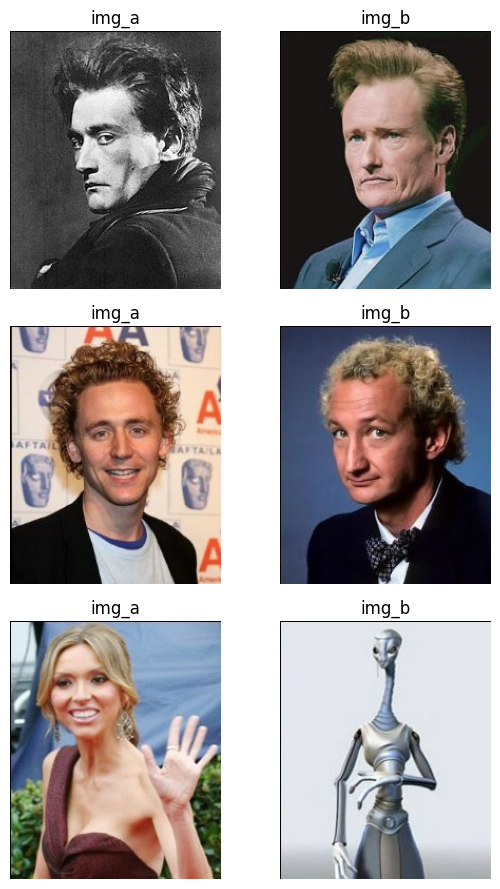

In [6]:
# Cell 4
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
CSV_PATH = DATA_DIR/"pairs.csv"
pairs_df.to_csv(CSV_PATH, index=False)
print("Wrote:", CSV_PATH.resolve(), "rows:", len(pairs_df))

# Preview a few random pairs as a grid
def show_random_pairs(df, n=4, size=3):
    sel = df.sample(n=min(n, len(df)), random_state=7)
    fig, axes = plt.subplots(len(sel), 2, figsize=(2*size, len(sel)*size))
    if len(sel) == 1: axes = np.array([axes])
    for i, (_, r) in enumerate(sel.iterrows()):
        for j, key in enumerate(["img_a","img_b"]):
            axes[i, j].imshow(Image.open(r[key]).convert("RGB"))
            axes[i, j].set_title(key)
            axes[i, j].axis("off")
    plt.tight_layout(); plt.show()

show_random_pairs(pairs_df, n=3)

In [7]:
# Cell 5
class TLLPairs(Dataset):
    """
    Returns (xa, xb, pair_id): positive pair from TLL (left,right).
    Negatives are created in the training step by shuffling within batch.
    """
    def __init__(self, csv_path, augment=True):
        self.df = pd.read_csv(csv_path)
        self.pairs = list(self.df.itertuples(index=False, name=None))

        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]
        self.train_tf = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.eval_tf = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.augment = augment

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        a_path, b_path = self.pairs[idx]
        xa = Image.open(a_path).convert("RGB")
        xb = Image.open(b_path).convert("RGB")
        tfm = self.train_tf if self.augment else self.eval_tf
        return tfm(xa), tfm(xb), idx  # use row index as pair id

In [8]:
# Cell 6
set_seed(42)

full_ds_train_mode = TLLPairs(CSV_PATH, augment=True)
N = len(full_ds_train_mode)
idx = np.arange(N)
train_idx, test_idx = train_test_split(idx, test_size=0.10, random_state=42)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.1111, random_state=42)  # 0.8/0.1/0.1

ds_train = Subset(full_ds_train_mode, train_idx)
ds_val   = Subset(TLLPairs(CSV_PATH, augment=False), val_idx)
ds_test  = Subset(TLLPairs(CSV_PATH, augment=False), test_idx)

BATCH_SIZE = 128
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, drop_last=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

len(ds_train), len(ds_val), len(ds_test)

(4812, 602, 602)

In [9]:
# Cell 7
class EmbeddingNet(nn.Module):
    def __init__(self, backbone="resnet18", out_dim=256, pretrained=True):
        super().__init__()
        if backbone == "resnet18":
            net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        else:
            net = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        feat_dim = net.fc.in_features
        net.fc = nn.Identity()
        self.backbone = net
        self.head = nn.Sequential(
            nn.Linear(feat_dim, out_dim),
            nn.BatchNorm1d(out_dim)
        )
    def forward(self, x):
        f = self.backbone(x)
        z = self.head(f)
        return F.normalize(z, dim=-1)

model = EmbeddingNet(backbone="resnet18", out_dim=256).to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6

11.308352

In [10]:
# Cell 8
def contrastive_loss(z1, z2, y, margin=0.5):
    # y ∈ {0,1}; L2 distance
    d = (z1 - z2).pow(2).sum(dim=1).sqrt()
    pos = y * d.pow(2)
    neg = (1 - y) * F.relu(margin - d).pow(2)
    return (pos + neg).mean()

def permute_as_negatives(z):
    b = z.size(0)
    perm = torch.randperm(b, device=z.device)
    if (perm == torch.arange(b, device=z.device)).any():
        perm = (perm + 1) % b
    return z[perm]

In [11]:
# Cell 9
LR = 3e-4
EPOCHS = 150
MARGIN = 0.5
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

best_val_posdist = float("inf")
CKPT_PATH = OUT_DIR/"best.pt"

for ep in range(1, EPOCHS+1):
    model.train()
    losses = []
    for xa, xb, _ in dl_train:
        xa, xb = xa.to(DEVICE), xb.to(DEVICE)
        za, zb = model(xa), model(xb)

        y_pos = torch.ones(za.size(0), device=DEVICE)
        y_neg = torch.zeros(za.size(0), device=DEVICE)

        # positive pair loss
        l_pos = contrastive_loss(za, zb, y_pos, margin=MARGIN)
        # negatives by permutation
        zb_neg = permute_as_negatives(zb)
        l_neg = contrastive_loss(za, zb_neg, y_neg, margin=MARGIN)

        loss = 0.5*(l_pos + l_neg)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())

    # simple validation: average positive distance (lower is better)
    model.eval(); dists = []
    with torch.no_grad():
        for xa, xb, _ in dl_val:
            xa, xb = xa.to(DEVICE), xb.to(DEVICE)
            za, zb = model(xa), model(xb)
            d = (za - zb).pow(2).sum(dim=1).sqrt()
            dists += d.tolist()
    val_posdist = float(np.mean(dists))
    print(f"Epoch {ep:02d} | train_loss={np.mean(losses):.4f} | val_pos_dist={val_posdist:.4f}")

    if val_posdist < best_val_posdist:
        best_val_posdist = val_posdist
        torch.save({"ep": ep, "state": model.state_dict()}, CKPT_PATH)
        print("  ✓ saved", CKPT_PATH)

Epoch 01 | train_loss=0.4191 | val_pos_dist=0.4691
  ✓ saved outputs/contrastive/best.pt
Epoch 02 | train_loss=0.1461 | val_pos_dist=0.2436
  ✓ saved outputs/contrastive/best.pt
Epoch 03 | train_loss=0.1018 | val_pos_dist=0.2261
  ✓ saved outputs/contrastive/best.pt
Epoch 04 | train_loss=0.0854 | val_pos_dist=0.2062
  ✓ saved outputs/contrastive/best.pt
Epoch 05 | train_loss=0.1064 | val_pos_dist=0.1862
  ✓ saved outputs/contrastive/best.pt
Epoch 06 | train_loss=0.0945 | val_pos_dist=0.2917
Epoch 07 | train_loss=0.0945 | val_pos_dist=0.2067
Epoch 08 | train_loss=0.0825 | val_pos_dist=0.2080
Epoch 09 | train_loss=0.1046 | val_pos_dist=0.1948
Epoch 10 | train_loss=0.0828 | val_pos_dist=0.1895
Epoch 11 | train_loss=0.0775 | val_pos_dist=0.1896
Epoch 12 | train_loss=0.0782 | val_pos_dist=0.2237
Epoch 13 | train_loss=0.0749 | val_pos_dist=0.2147
Epoch 14 | train_loss=0.0727 | val_pos_dist=0.2140
Epoch 15 | train_loss=0.0772 | val_pos_dist=0.2164
Epoch 16 | train_loss=0.0789 | val_pos_dist=0

In [12]:
# Cell 10
# Convention: queries = left (img_a), gallery = right (img_b)
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["state"]); model.eval()

eval_tfm = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def embed_paths(paths):
    embs = []
    with torch.no_grad():
        for p in paths:
            img = Image.open(p).convert("RGB")
            x = eval_tfm(img).unsqueeze(0).to(DEVICE)
            z = model(x).cpu().numpy()[0]
            embs.append(z)
    return np.stack(embs, axis=0)

# Use the WHOLE CSV for retrieval evaluation
all_df = pd.read_csv(CSV_PATH)
Q_paths = all_df["img_a"].tolist()
G_paths = all_df["img_b"].tolist()
labels = np.arange(len(all_df))  # each row is a unique "class"

Q_emb = embed_paths(Q_paths)
G_emb = embed_paths(G_paths)

Q_emb.shape, G_emb.shape

((6016, 256), (6016, 256))

In [13]:
# Cell 11
nn = NearestNeighbors(n_neighbors=10, metric="cosine").fit(G_emb)
dist, idx = nn.kneighbors(Q_emb, n_neighbors=10)

g_labels = labels  # gallery labels per row
q_labels = labels  # query label == its row id
retrieved_labels = g_labels[idx]

def recall_at_k(q_lab, topk_lab, K):
    return (q_lab[:,None] == topk_lab[:, :K]).any(axis=1).mean()

def mean_ap_at_k(q_lab, topk_lab, K):
    ap = []
    for q, row in zip(q_lab, topk_lab):
        pos = np.where(row[:K] == q)[0]
        ap.append(0.0 if len(pos)==0 else 1.0/(pos[0]+1))
    return float(np.mean(ap))

for K in [1,5,10]:
    r = recall_at_k(q_labels, retrieved_labels, K)
    m = mean_ap_at_k(q_labels, retrieved_labels, K)
    print(f"Recall@{K}: {r:.4f} | mAP@{K}: {m:.4f}")

Recall@1: 0.0065 | mAP@1: 0.0065
Recall@5: 0.0163 | mAP@5: 0.0097
Recall@10: 0.0269 | mAP@10: 0.0111


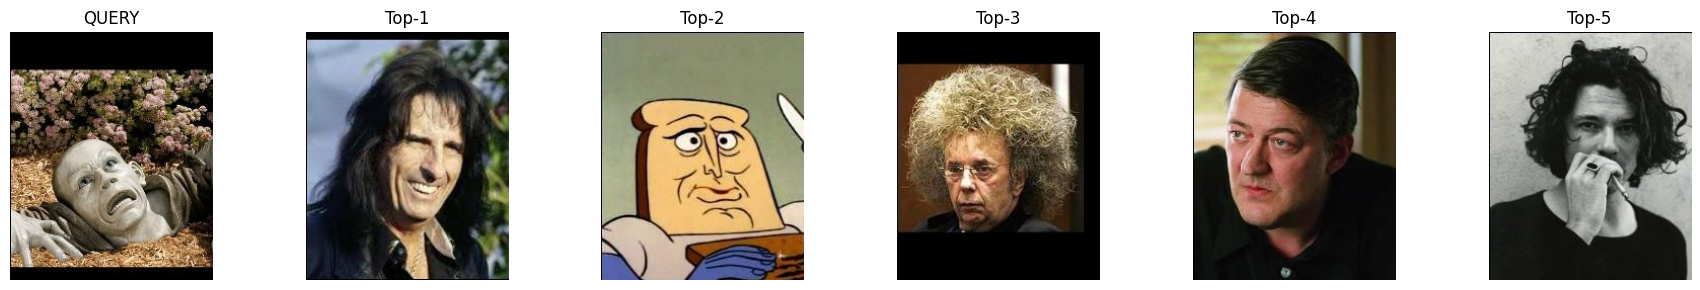

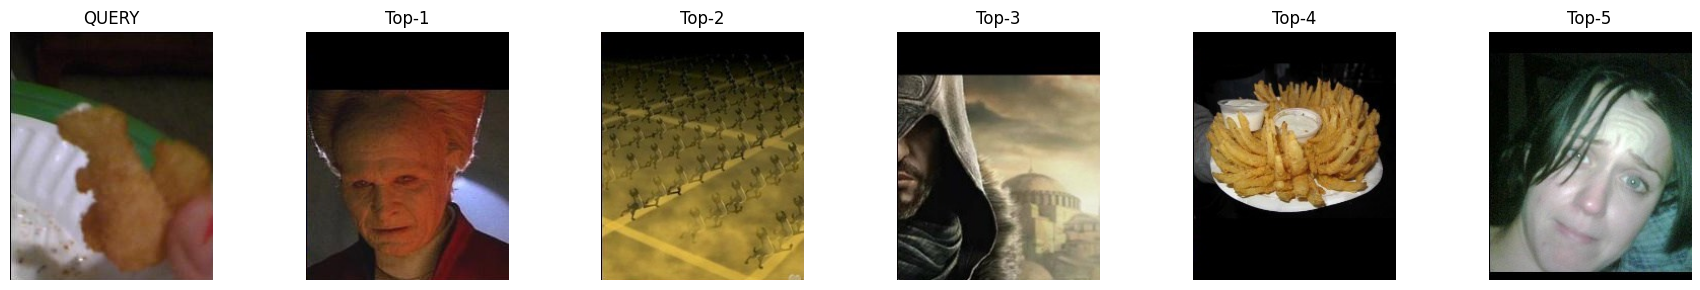

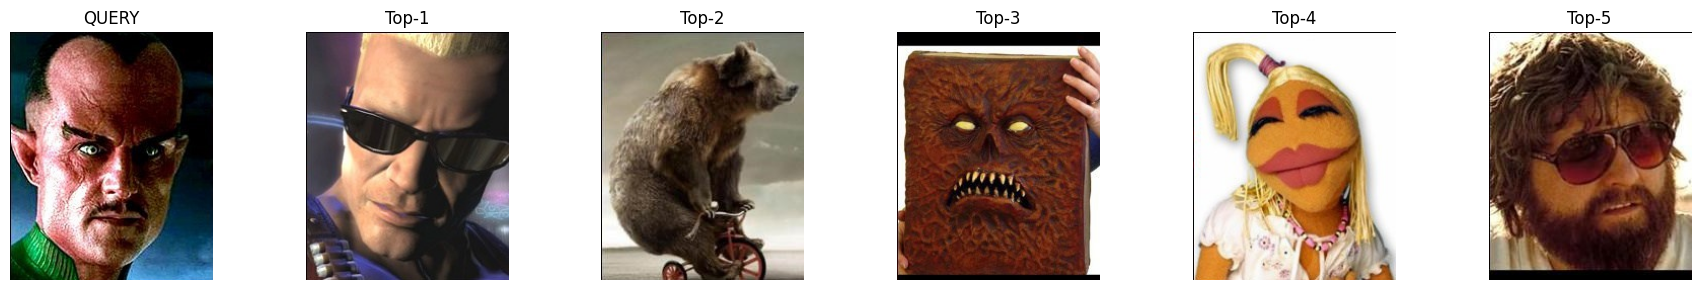

In [14]:
# Cell 12
def show_topk_for(query_idx, topk=5):
    q_path = Q_paths[query_idx]
    top_idx = idx[query_idx][:topk]
    top_paths = [G_paths[i] for i in top_idx]
    titles = ["QUERY"] + [f"Top-{i+1}" for i in range(topk)]
    imgs = [Image.open(q_path).convert("RGB")] + [Image.open(p).convert("RGB") for p in top_paths]

    plt.figure(figsize=(3* (topk+1), 3))
    for i, (im, t) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, topk+1, i+1)
        ax.imshow(im); ax.set_title(t); ax.axis("off")
    plt.tight_layout(); plt.show()

for q in [0, 1, 2]:  # change indices to inspect different queries
    show_topk_for(q, topk=5)

In [15]:
# Cell 13
def save_grid_for(query_idx, topk=5, out_path=OUT_DIR/f"q{0}_top{5}.png"):
    q_path = Q_paths[query_idx]
    top_idx = idx[query_idx][:topk]
    top_paths = [G_paths[i] for i in top_idx]
    imgs = [Image.open(q_path).convert("RGB")] + [Image.open(p).convert("RGB") for p in top_paths]
    # Resize to same shape
    imgs = [im.resize((224,224)) for im in imgs]
    tensor = torch.stack([transforms.ToTensor()(im) for im in imgs], dim=0)
    grid = tvutils.make_grid(tensor, nrow=topk+1, padding=8)
    tvutils.save_image(grid, out_path)
    return out_path

path = save_grid_for(0, topk=5, out_path=OUT_DIR/"example_query_top5.png")
path

PosixPath('outputs/contrastive/example_query_top5.png')